# AP Grades Report

## Introduction
The goal of this project was to use grades data from my AP classes to predict scores on the AP Exam. AP Exams are given to high school students who wish to possibly get college credit in a course. The exams are graded on a 1 - 5 scale, 1 being the worst, 5 being the best. "Passing" an AP exam and possibly getting college credit has traditionally been seen as getting at least a 3 on the exam. Having been a mathematics teachers for the past 5 years I have accumulated a decent amount of data from year to year in my courses. I have data within AP Calculus BC and AP Statistics. For the purposes of this project I will only be using AP Calculus BC data and will be cleaning, visualizing, and doing predictive modeling. These processes could be applied the exact same for the AP Statistic data as well. 

## Data Collection:

Grades data was collected from a learning management system, all names were randomized and anonomized. Ordered pairs of initials are used to differentiate from student to student. The order pairs have no relationship to students actual initials unless by chance.

Initial data looked in this form: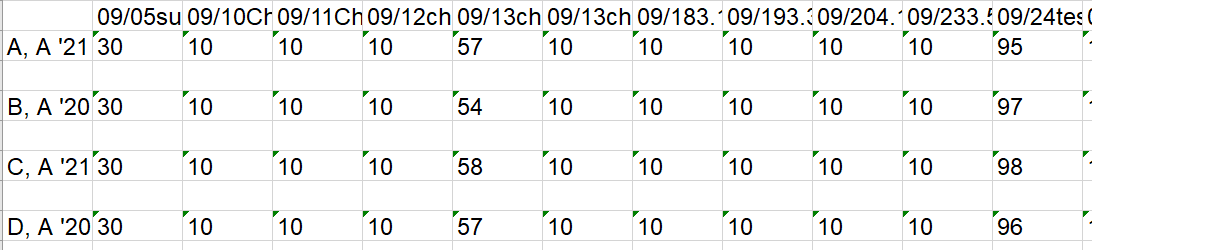

This snippet of data is for one quarter of the school year for one AP Calculus BC class. There are 3 main categories for grades:

* Tests - Worth 65% of cummulative grade
* Quizzes - Worth 25% of cummulative grade
* Homework - Worth 10% of cummulative grade

All data file labels have the following layout:

##### YEAR_class#_Q#
* YEAR - the year in which the class began
* class# - The class label and section number - ex: "BC1"
* Q# - The quarter in which the data is for: Ranging from Q1 to Q4




### Data Cleaning

Cleaning of the data would go as follows:
* Remove homework grades entirely - Homework would generally average to a 100%, making it a poor indicator for any predictions
* Calculate average quiz and test grades from a given quarter
* Using the name column extract students graduation year - Always the last 2 digits of their name
* Using graduation year along with current school year (found in filename) find the class standing of a student (i.e Freshman, Sophomore, Junior, or Senior)

In addition to raw grades data I compiled another data set for each class consisting of some grades not found in the learning management system. Below is what this data looks like: 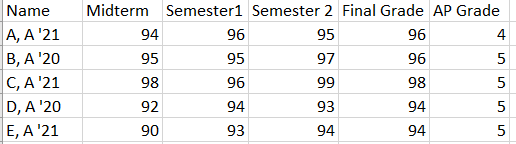

"AP Grade" is the variable we are trying to predict. The Semester grades are calculated based on a students quarter averages

Compile all transformations accross all years, sections, and quarters to get our cleaned data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os
import glob
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import (GaussianNB, MultinomialNB)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
######################################################################
# Data Cleaning and Transforming Functions
######################################################################

#function to determine if student is freshman, sophomore, junior, or senior
def class_standing(vec):
    grad_year = vec[0]
    school_year_end = int(vec[1][-2:])
    if grad_year - school_year_end ==0:
        return('Senior')
    elif grad_year - school_year_end ==1:
        return('Junior')
    elif grad_year - school_year_end ==2:
        return('Sophomore')
    elif grad_year - school_year_end ==3:
        return('Freshmen')
    else:
        return('Other')


    
#Function to calculate average test and quiz as well as combine all quarters of a section into one dataframe
def compile_grades(file_loc):
    
    #extract import information from file_loc which should be in form:
    # "YEAR_class#_Q#"
    # where YEAR is the year at which the class began
    # class# is the class and section number (ex: BC1)
    # Q# is the quarter that the grades were from, if AP then this is the file
        #that contains AP grades and some other valuable grades

    school_year_start = file_loc[2:4] 
    school_year_end = (int(school_year_start)+1)
    school_year = school_year_start + '-' + str(school_year_end)
    quarter = file_loc[-7:-5]
    
    
    #Check if file is AP scores first
    if quarter=='AP':
        df=pd.read_excel(file_loc)
        return df
    
    
    else:
        #read in spreadsheet
        df = pd.read_excel(file_loc, skiprows=1)
    
        #CLEANING DATA
        #shift cummulative grade up 1 to be in line with other grades for a student
        df['Cum.\nGrade'] = df['Cum.\nGrade'].shift(-1)

        #drop rows with NA, this should drop every other row, because they are entirely NA now
        df=df.dropna(subset=['Unnamed: 0'])

        #Drop columns that contain "HW", Homework grades aren't important enough
        df = df[df.columns.drop(list(df.filter(regex='HW')))]
    
        # Rename the Name column and Cummulative grade column, these will be kept
        df = df.rename(columns={'Unnamed: 0': 'Name', 'Cum.\nGrade': quarter+'_Avg'})
    
        # Student name has class year as last 2 characters, extract those for grad year column
        df = (df.assign(grad_year=df['Name'].str[-2:]))
        df['grad_year'] = pd.to_numeric(df['grad_year'])
    
        #re-arrange the columns to have [Name, Grad_Year, school_year] as the first 3
        df.insert(1, "Grad_Year", df['grad_year'])
        df.insert(2, 'school_year', school_year)
        df=df.drop('grad_year', axis=1)
    
        #calculate average test and quiz grades
        for test_or_quiz in ['Test','Quiz']:
        
            #get total points for assessments from column names (last 3 characters)
            point_totals = pd.Index(map(lambda x : str(x)[-3:], df.filter(like=test_or_quiz).columns))
            point_totals = pd.to_numeric(point_totals.tolist())
        
            #extract and convert columns that are current assessment type and divide by point_totals to get decimal percents
            assessment_percents = df.filter(like=test_or_quiz) / point_totals
        
            # Calculate the average for current assessment type and merge with current df
            out = pd.Series(assessment_percents.mean(axis=1).round(4)*100, name=quarter+'_'+test_or_quiz+'_avg') 
            df = pd.merge(df, out, left_index=True, right_index=True)

        #Drop old assessment columns leaving only [Q#_avg, Q#_Test_avg, Q#_Quiz_avg] for grades data
        df = df[df.columns.drop(list(df.filter(regex='Max')))]

        return df

In [3]:
######################################################################
# The below code is used to compile each year and class one at a time to 
# make individual files for each. Currently I have 2019 BC2 as an example.
######################################################################

#Iterate over all files for grades
count=1

#change path to directory with data
try:
    os.chdir('BC')
except:
    pass

#Year 2019 data is to be compiled
for file_loc in ['2019 BC2 Q1.xlsx','2019 BC2 Q2.xlsx','2019 BC2 Q3.xlsx','2019 BC2 Q4.xlsx','2019 BC2 AP.xlsx']:
    df_out = compile_grades(file_loc)

    if count==1:
        df = df_out
        count = count+1

    df = pd.merge(df,df_out)
    
    
#add class standing and move to 4th column
df['class_standing'] = df[['Grad_Year','school_year']].apply(class_standing, axis=1)
col = df.pop('class_standing')
df.insert(3, col.name, col)

#Save compiled data to csv
df.to_csv('2019_BC2_clean.csv', index=False)

In [11]:
######################################################################
# Once all years and class sections have been cleaned I combine all these 
#files into one master CSV file, this file will be read in for any future uses.
######################################################################


#combine all cleaned grades into one dataframe
#only need the .csv files
all_files = glob.glob('*.{}'.format('csv'))

#initialize list for df to go get appended to
flist=[]

#iterate over all csv files in directory
for file in all_files:
    df_temp = pd.read_csv(file, index_col=False)
    flist.append(df_temp)

#concatinate all df in the flist
df_out = pd.concat(flist, axis=0, ignore_index=False)

#save to csv
df_out.to_csv('ALL_BC_cleaned.csv', index=False, mode = 'w')

The data is now cleaned and all compiled into one file, "ALL_BC_cleaned.csv"

Here is a snippit of the data for quarters 1 and 2:

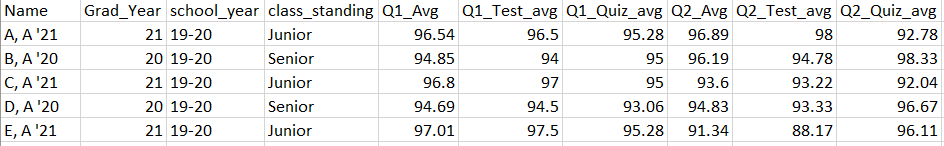

Note: our cleaned data has 79 responses and 21 variables in total

# Data Exploration

For data visualizations and prediction of AP grades I decided to only use the Quarter averages (Q1_Avg, Q2_Avg, Q3_Avg, Q4_Avg), semester grades (Semester1, Semester 2), midterm grade, and final grade. These grades are made up of the test and quiz averages found in the cleaning step. I removed any student who does not have an AP Grade listed. This leaves use with 70 responses and 9 variables for prediction. "class_standing" is also kept for visualization purposes.

Below is a snippet of the data selected along with the summary statistics for the quantitative variables

In [4]:
try:
    os.chdir('BC')
except:
    pass

#Read in cleaned data, drop any rows without an AP Grade
df_raw = pd.read_csv('ALL_BC_cleaned.csv')

#select only most important variables
df = df_raw[['class_standing','Q1_Avg','Q2_Avg','Midterm','Q3_Avg','Q4_Avg','Semester1','Semester 2','Final Grade','AP Grade']]
df = df.dropna(subset=["AP Grade"])
df2 = df.drop('class_standing',axis=1)
df.head()

,class_standing,Q1_Avg,Q2_Avg,Midterm,Q3_Avg,Q4_Avg,Semester1,Semester 2,Final Grade,AP Grade
0,Junior,96.54,96.89,94,89.67,98.56,96.0,95.0,96.0,4.0
1,Senior,94.85,96.19,95,93.08,97.92,95.0,97.0,96.0,5.0
2,Junior,96.80,93.60,98,89.65,88.54,96.0,99.0,98.0,5.0
3,Senior,94.69,94.83,92,89.56,95.50,94.0,93.0,94.0,5.0
4,Junior,97.01,91.34,90,89.93,98.47,93.0,94.0,94.0,5.0


In [5]:
df.describe().round(2)

,Q1_Avg,Q2_Avg,Midterm,Q3_Avg,Q4_Avg,Semester1,Semester 2,Final Grade,AP Grade
count,70.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,91.67,91.93,88.11,86.36,94.56,91.13,90.81,91.18,3.66
std,6.34,6.20,8.95,10.35,5.83,6.29,7.39,6.57,1.31
min,72.26,72.04,60.00,48.54,70.62,73.80,70.00,72.00,1.00
25%,89.81,89.36,83.00,83.13,91.72,88.65,88.88,90.06,3.00
50%,93.65,93.64,90.00,89.66,96.46,92.80,93.75,93.20,4.00
75%,96.02,96.19,94.75,93.05,98.54,95.85,96.00,96.00,5.00
max,99.57,101.22,100.00,99.50,100.62,99.20,100.00,100.00,5.00


Next, a quick view at the relationships between the variables having scatterplots for each pair of quantitative variables and histograms along the main diagonal. Below these graphs I've also included the correlation coefficients for each pairing.

We see that when looking at grades that I give (everything but the AP Grade) there is generally a strong positive linear relationship with most correlations being above 0.7. Students who do well in one area of the year tend to do well in all the others.

The relationships between AP Grades (i.e. the last row below) do show some positive linear relationships that are only slightly lower than others. 

The variable I find most interesting here would be Q4_Avg. We see correlations dip as low as 0.53. In the world of AP classes quarter 4 is generally the easiest quarter. Half of the quarter is devoted to review for the AP Exam and the other half takes place after the AP Exam is completed. Generally this leads to higher grades (94.6% from the table above) even for those students who struggled the entire year.

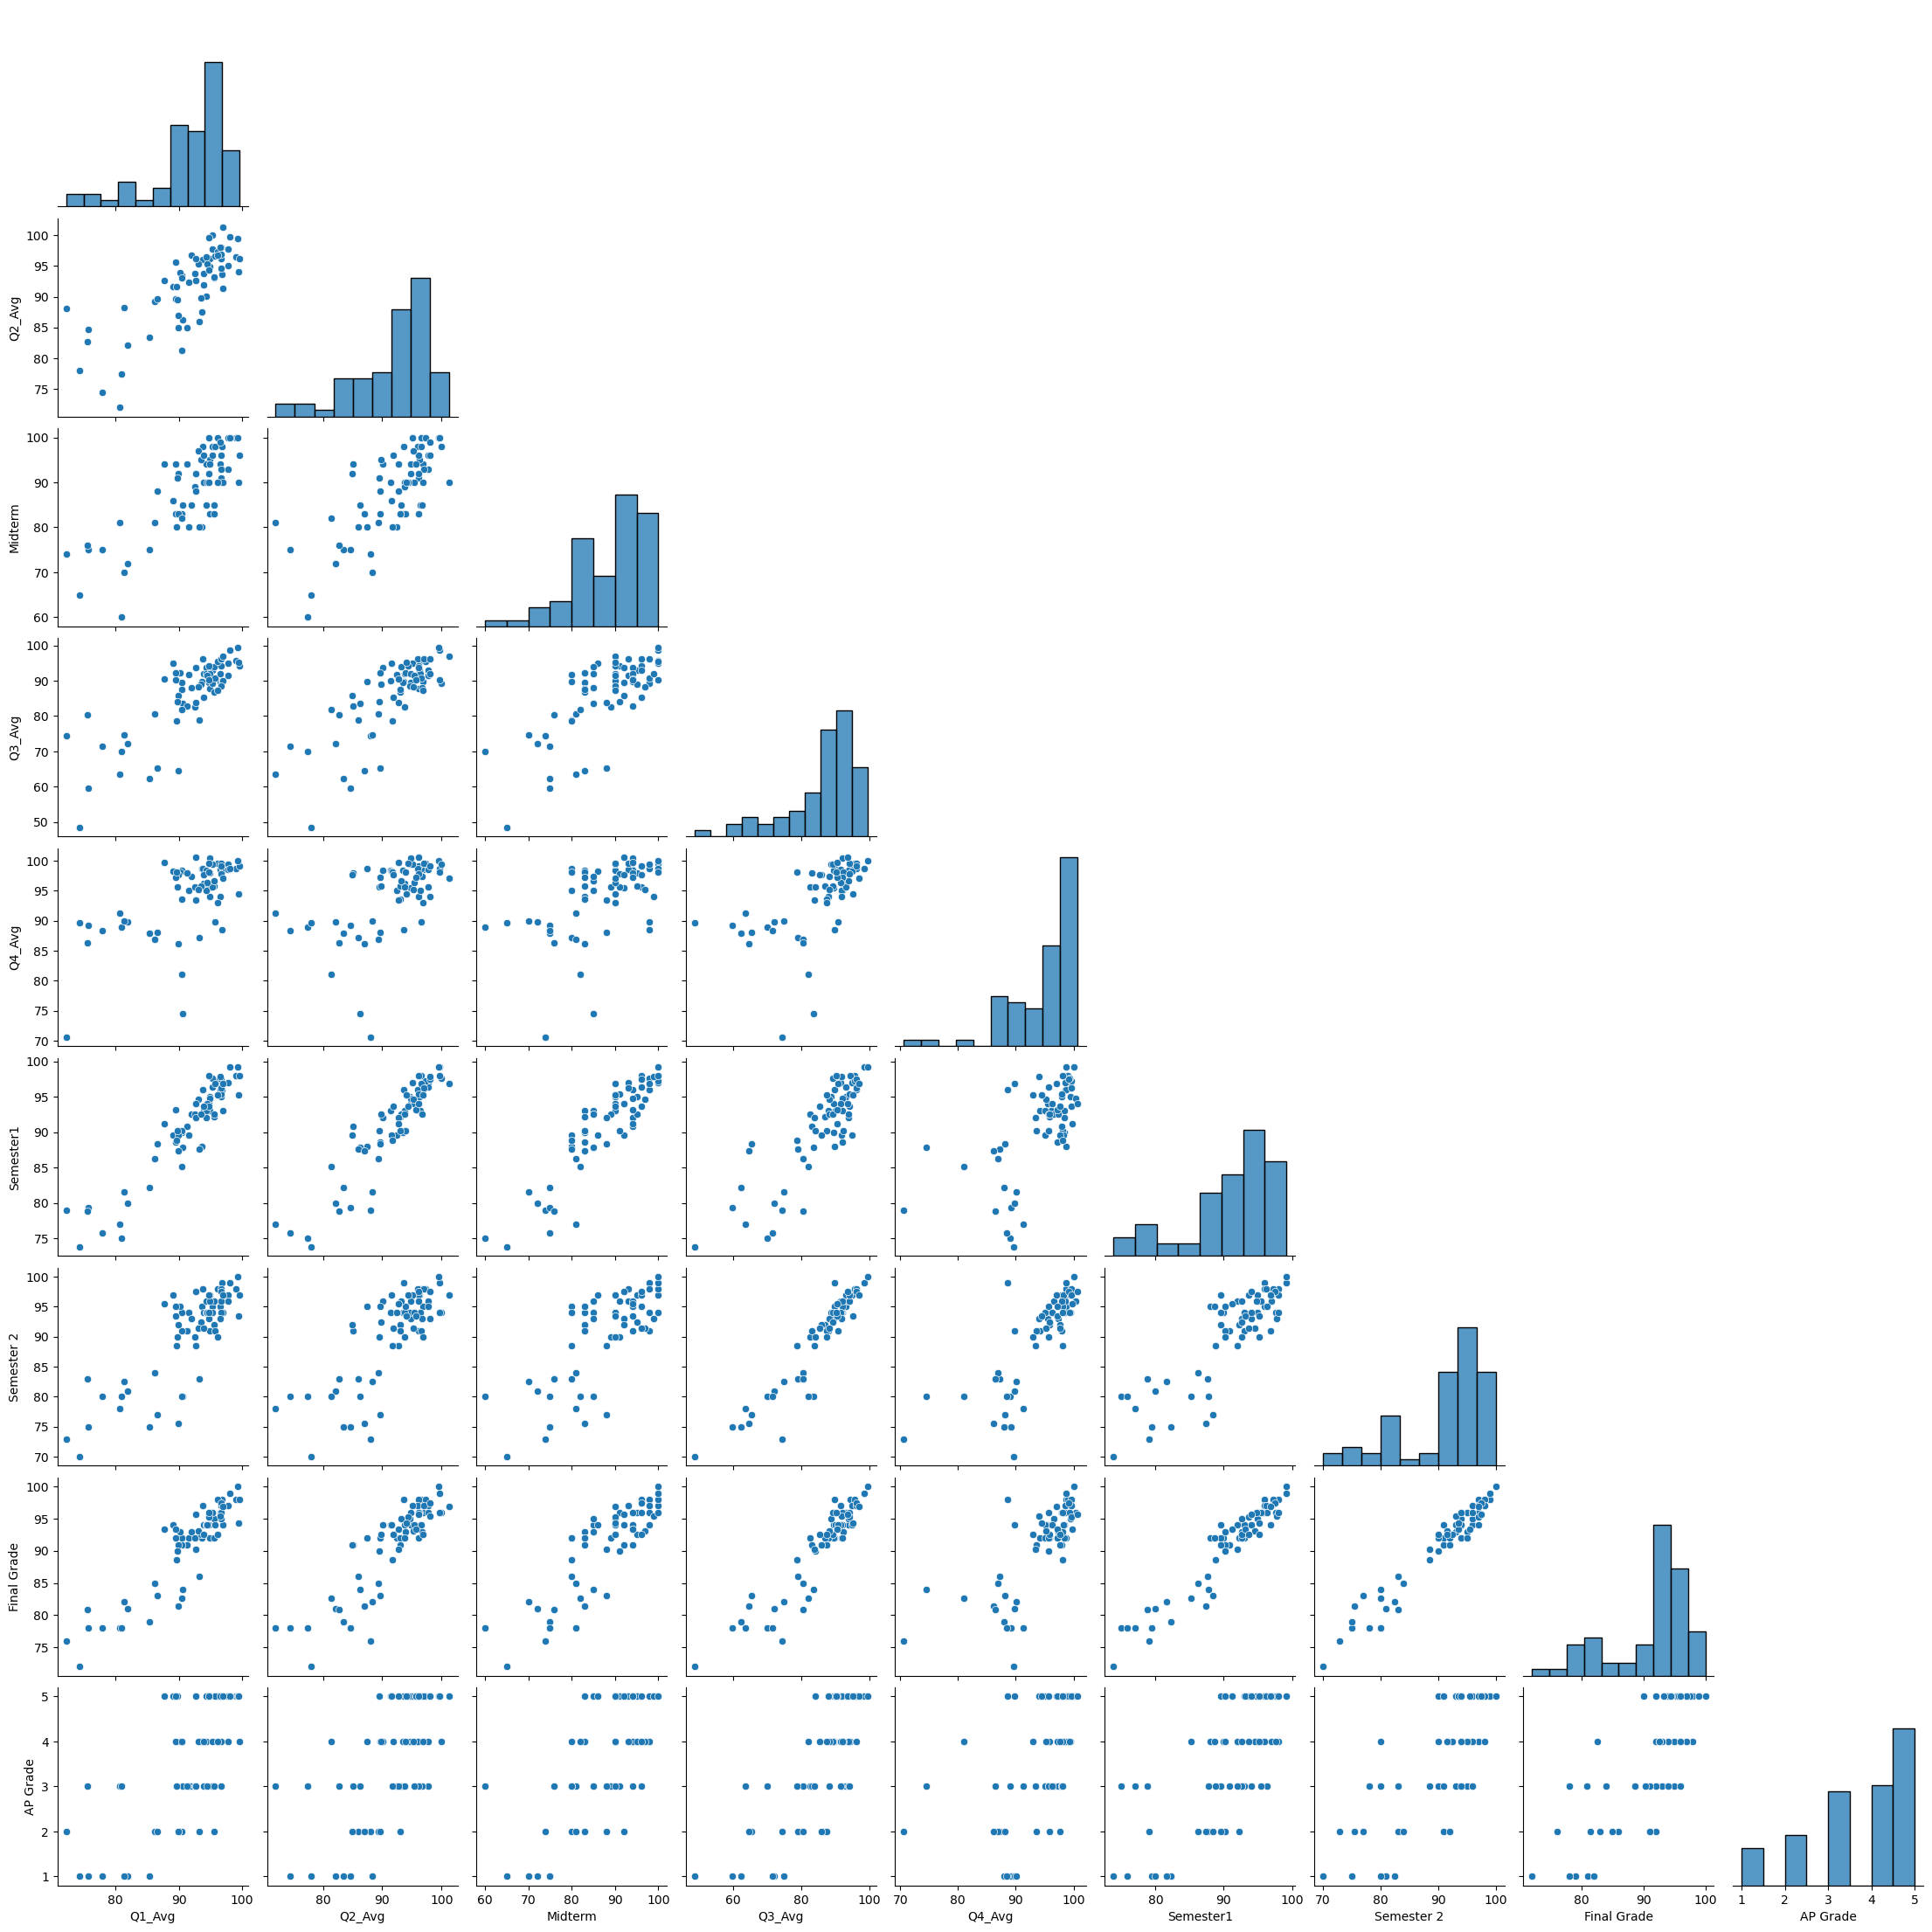

In [6]:
sns.pairplot(df, corner=True)

In [7]:
corr = df2.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,Q1_Avg,Q2_Avg,Midterm,Q3_Avg,Q4_Avg,Semester1,Semester 2,Final Grade,AP Grade
Q1_Avg,nan,nan,nan,nan,nan,nan,nan,nan,nan
Q2_Avg,0.78,nan,nan,nan,nan,nan,nan,nan,nan
Midterm,0.78,0.73,nan,nan,nan,nan,nan,nan,nan
Q3_Avg,0.80,0.79,0.73,nan,nan,nan,nan,nan,nan
Q4_Avg,0.62,0.56,0.56,0.61,nan,nan,nan,nan,nan
Semester1,0.93,0.92,0.90,0.84,0.63,nan,nan,nan,nan
Semester 2,0.82,0.78,0.75,0.94,0.81,0.85,nan,nan,nan
Final Grade,0.90,0.87,0.85,0.93,0.76,0.95,0.97,nan,nan
AP Grade,0.68,0.64,0.71,0.76,0.53,0.72,0.76,0.77,nan


### Class Standing Visualizations

From here I wanted to look at grade distributions by class standing (freshman, sophomore, junior, senior). First via bar charts on the average grades for each class standing. Note that there was only 1 freshman in my data set so no error bar is shown.

We see that seniors generally are the lowest performers with the highest variance. 

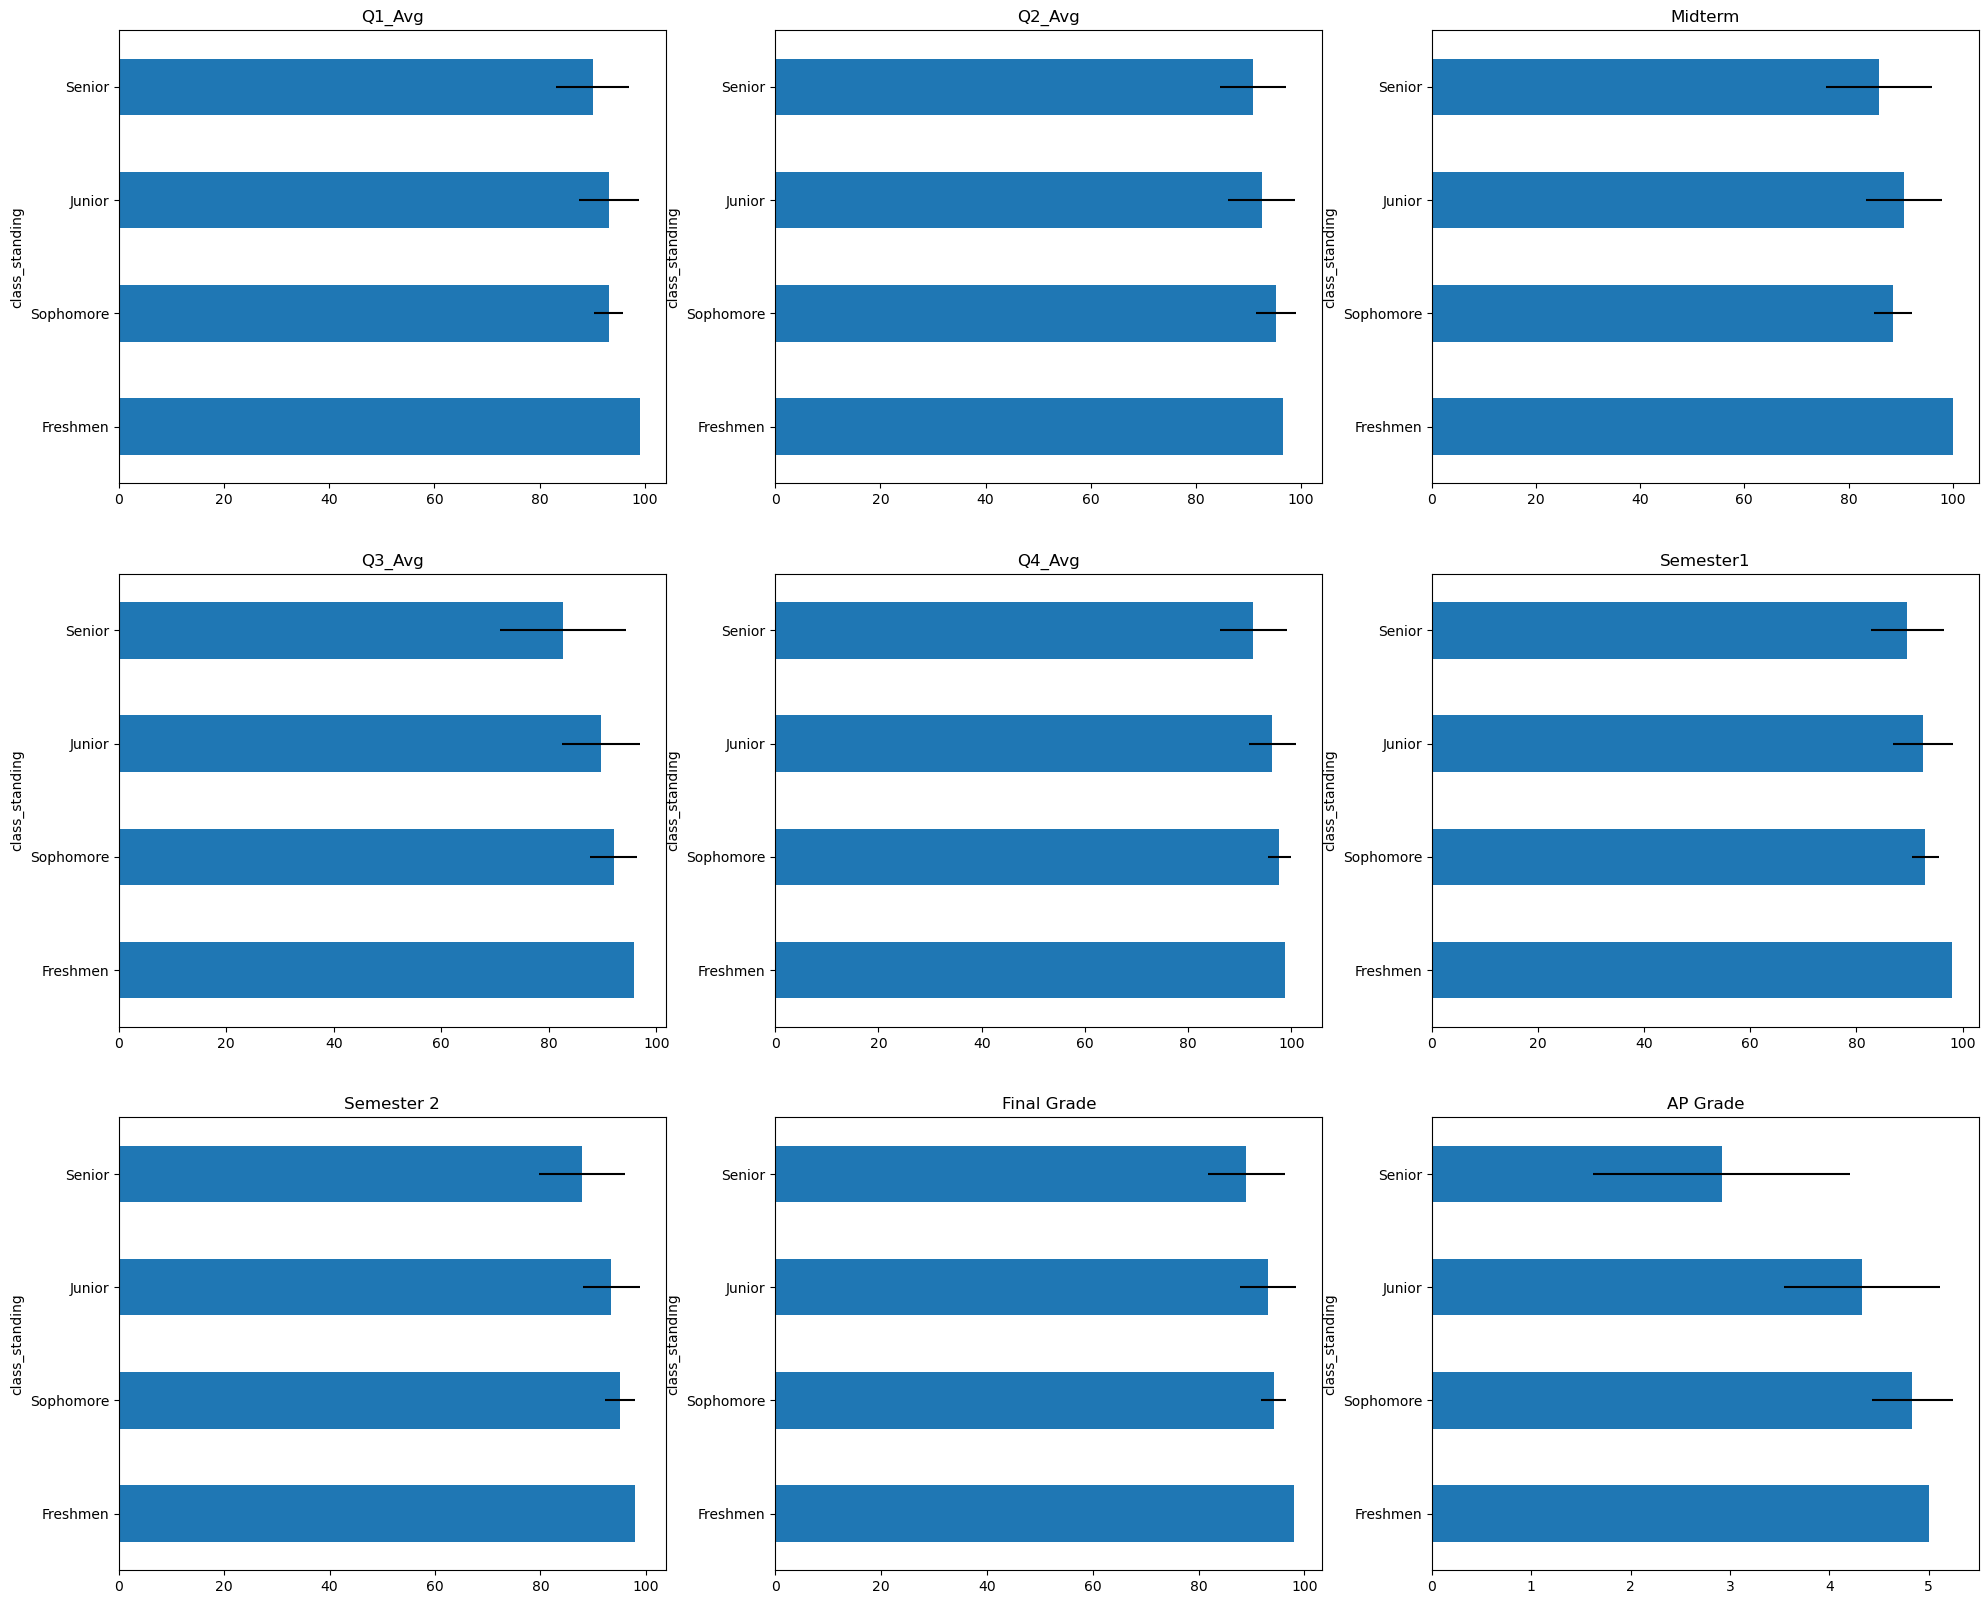

In [8]:
#distribution by class_standing
df_class = df.groupby('class_standing').agg(['size','mean',np.std])
df_class = df_class.reindex(['Freshmen','Sophomore','Junior','Senior'])

i=0
j=0

fig, axes = plt.subplots(len(df_class.columns.get_level_values(0).drop_duplicates())//3, 3, figsize=(24, 20))

#barchart comparison by class_standing
for col in df_class.columns.get_level_values(0).drop_duplicates():
    temp_df = df_class[col]
    temp_df.plot(kind = "barh", y = "mean", legend = False, xerr = "std", title = col, ax=axes[j,i])
    i+=1
    if i==3:
        i=0
        j+=1
    
plt.show()

To go further into the relationship between class standing and grades I made density plots for all variables. The 1 freshman data point could not be included in this data because a density plot can't be constructed with only one data point.

From these plots we can see that skewness tends to increase as class standing increases (i.e. students get older). With a student being able to make it to AP Calculus BC by sophomore or junior year is an impressive feat so these students are generally high achieving. Seniors on the other hand often fall victum to "senioritis", AKA they get lazy their final year or they are overworked from the college application process.

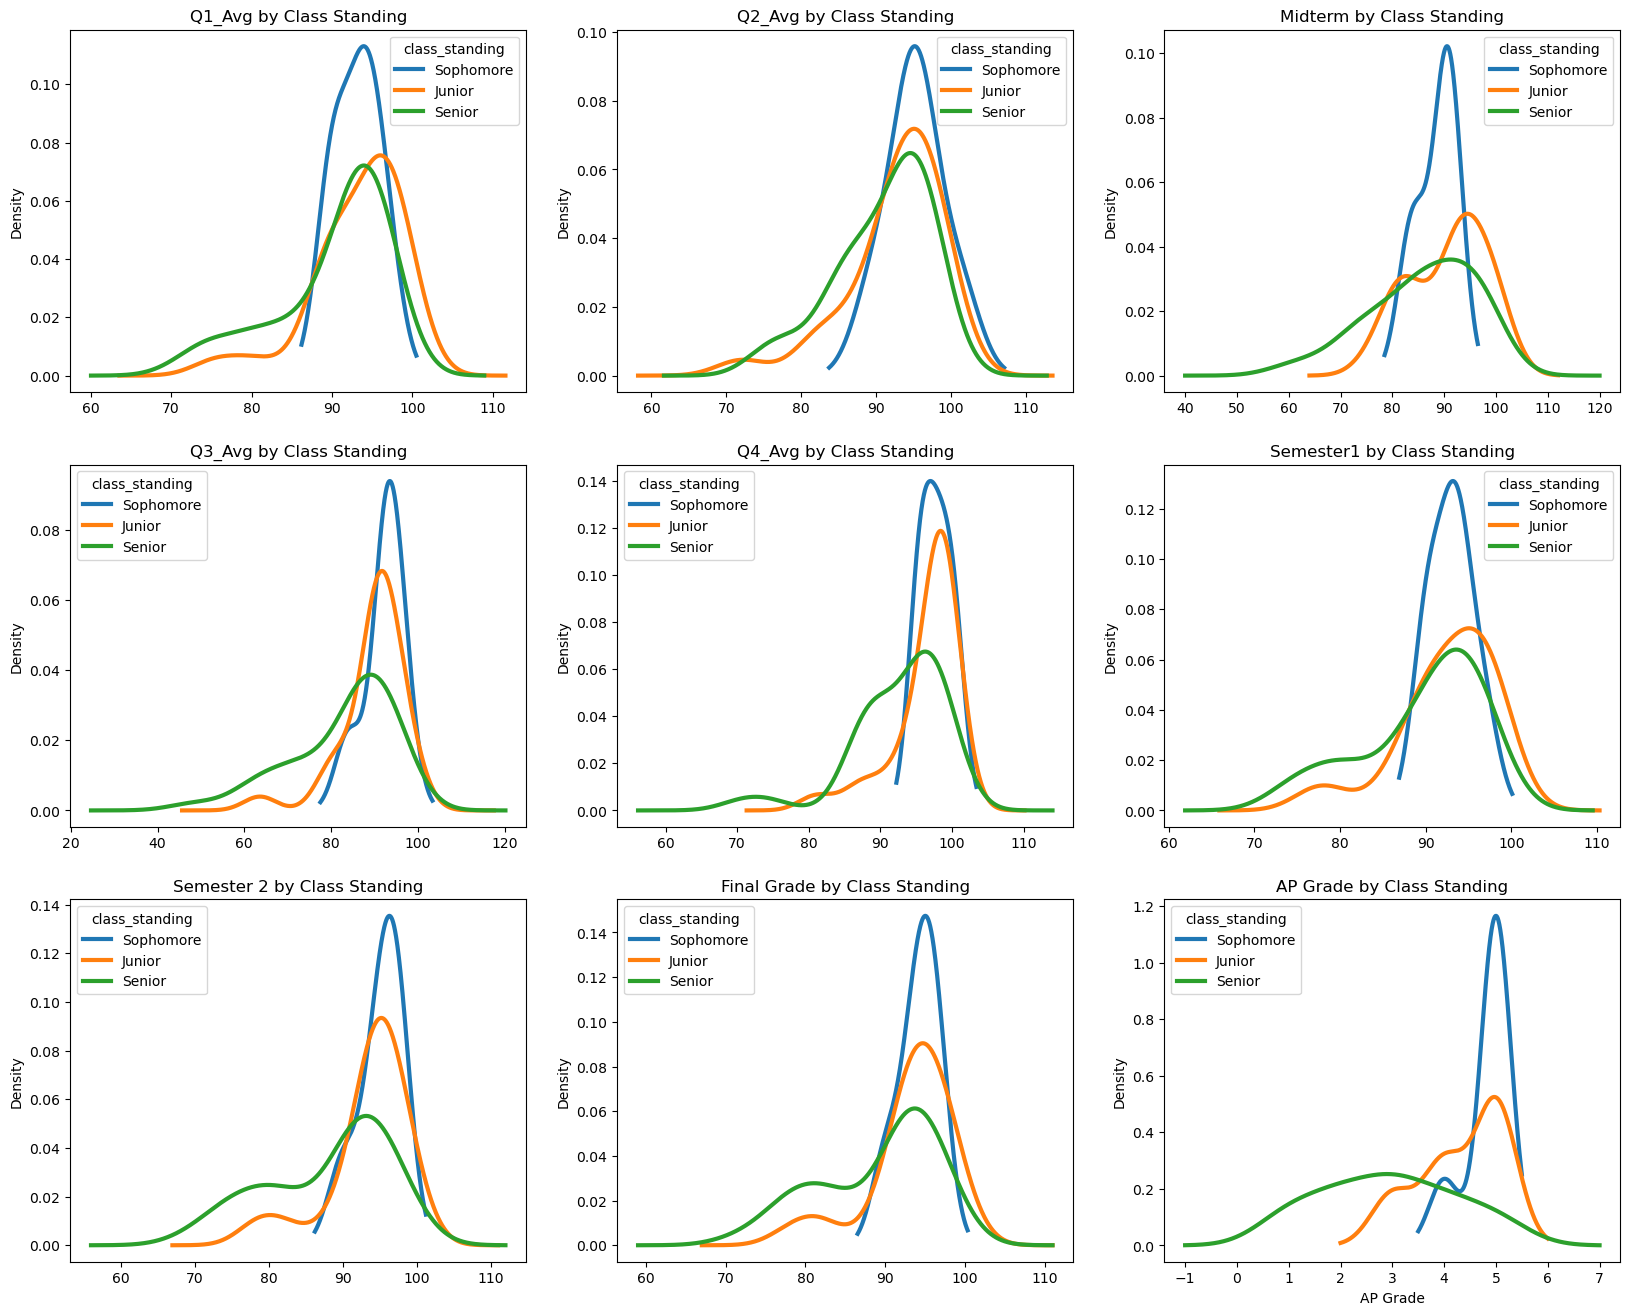

In [9]:
#visualizations AP Score by class_standing
fig, axes = plt.subplots(len(df_class.columns.get_level_values(0).drop_duplicates())//3, 3, figsize=(20, 16))
i=0
j=0

for col in df_class.columns.get_level_values(0).drop_duplicates(): 
    #Freshman has the be dropped because only 1 student has been a freshman
    data_wide = df.pivot(columns = 'class_standing', values = col)[['Sophomore','Junior','Senior']]

    # plotting multiple density plot 
    data_wide.plot.kde(linewidth = 3, ax=axes[j,i], title=(col+' by Class Standing'))
#    plt.title(col + ' by Class Standing')
    plt.xlabel(col)

    
    i+=1
    if i==3:
        i=0
        j+=1
    


Finally, I wanted to analyze dimensional reduction (principal components) to see if any trend could be seen on AP Grade. I first standardized the data before running principal components. Below I graphed the first 2 principal components colored by AP Grade. The variance explained for the first 3 principal components is shown as well above the graph, we see that the first component takes into account nearly 81% of the variances. These grades data are all intertwined quite strongly!

From this visualization I can't make out any obvious trends as to a students AP grade and their component scores. 

     Variance Explained
PC1               0.806
PC2               0.065
PC3               0.047


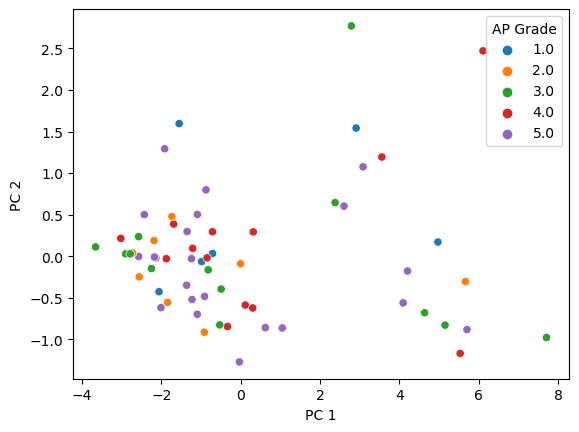

In [10]:
df_standardized = StandardScaler().fit_transform(df.drop(['class_standing'],axis=1))
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_standardized)
df_PC = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3'])
print (pd.DataFrame(pca.explained_variance_ratio_.round(3), ['PC1','PC2','PC3'], columns=['Variance Explained']))

df_PC['AP Grade'] = df['AP Grade']
df_PC.sort_values('AP Grade')

sns.scatterplot(data=df_PC, x='principal component 1', y='principal component 2', hue='AP Grade', palette=["C0", "C1", "C2", "C3",'C4'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Prediction Modeling

These are the 6 models I will be using for predicting AP Grades

### Multi-Class Classifcations:
* k-Nearest Neighbors
* Decision Trees
* Gaussian Naive Bayes
* Multi Naive Bayes
* Random Forest
* Gradient Boosting


For each method bootstrapping was used across 100 random train/test samples at an 80-20 split to get accuracy scores for each.

From the output below we see that Gaussian Naive Bayes was the most accurate model at 47.6%. Considering that there are 5 possible outcomes this is not too bad. For a comparison there are 25 students who recieved a 5 on the exam, this is about 36% of responses (25/70) so the models are all doing slightly better than if it were to just predict 5s for every student.

In [11]:
accuracy = []

#KNN
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    random_state.append(knn.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))



#Decision Trees
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    random_state.append(clf.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))



#Gaussian Naive Bayes
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    gnb = GaussianNB()
    gnb = gnb.fit(X_train, y_train)
    random_state.append(gnb.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))



#Multi Naive Bayes
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    mnb = MultinomialNB()
    mnb = mnb.fit(X_train, y_train)
    random_state.append(mnb.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))


#Random Forest
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    rf = RandomForestClassifier(max_depth=4, random_state=0)
    rf.fit(X_train, y_train)
    random_state.append(rf.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))



#Gradient Boosting
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['class_standing','AP Grade'], axis=1), df['AP Grade'], test_size=0.2, random_state=i)
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    gb = gb.fit(X_train, y_train)
    random_state.append(gb.score(X_test,y_test))

accuracy.append(np.mean(random_state).round(3))



models = ['KNN','Decision Tree','Gaussian Naive Bayes','Multi Naive Bayes','Random Forest','Gradient Boosting']
acc_out = pd.DataFrame(accuracy,models, columns=['Accuracy'])
acc_out

,Accuracy
KNN,0.401
Decision Tree,0.379
Gaussian Naive Bayes,0.476
Multi Naive Bayes,0.395
Random Forest,0.444
Gradient Boosting,0.445


### Pass/Fail Predictions
A passing grade is considered to be at least a 3 on the AP Exam. Because of this we can make our model into a binary prediction instead of multiclass prediction. The variable AP Grade was replaced with the variable "PassFail" where 1 is pass and 0 is fail. Again bootstrapping is done 100 times at an 80-20 split for train/test. The 5 classification techniques I used are as follows:


### Binary Classifications:
* Logistic Regression
* k-Nearest Neighbors
* Decision Trees
* Support Vector Machine
* Naive Bayes (Gaussian)

From the output below we see that Gaussian Naive Bayes again performed the best with 88.6% accuracy, quite strong. Looking at the ratio of passing students to failing there are 14 students who failed (20%) and 56 who passed (80%). This means apart from the decision tree model all processes have a slightly better accuracy than just pure guessing based off prior knowledge. 

In [16]:
def passfail(grade):
    if grade>=3:
        return(1)
    else:
        return(0)

df_bin = df.copy()
df_bin['PassFail'] = df['AP Grade'].apply(passfail)
df_bin = df_bin.drop(['AP Grade'], axis=1)

binary_accuracy = []




#KNN
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(['class_standing','PassFail'], axis=1), df_bin['PassFail'], test_size=0.2, random_state=i)
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train, y_train)
    random_state.append(knn.score(X_test,y_test))

binary_accuracy.append(np.mean(random_state).round(3))




#Decision Trees
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(['class_standing','PassFail'], axis=1), df_bin['PassFail'], test_size=0.2, random_state=i)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    random_state.append(clf.score(X_test,y_test))

binary_accuracy.append(np.mean(random_state).round(3))



#Gaussian Naive Bayes
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(['class_standing','PassFail'], axis=1), df_bin['PassFail'], test_size=0.2, random_state=i)
    gnb = GaussianNB()
    gnb = gnb.fit(X_train, y_train)
    random_state.append(gnb.score(X_test,y_test))

binary_accuracy.append(np.mean(random_state).round(3))



#Logistic Regression
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(['class_standing','PassFail'], axis=1), df_bin['PassFail'], test_size=0.2, random_state=i)
    lg = LogisticRegression()
    lg = lg.fit(X_train, y_train)
    random_state.append(lg.score(X_test,y_test))

binary_accuracy.append(np.mean(random_state).round(3))



#Support Vector Machine
random_state = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_bin.drop(['class_standing','PassFail'], axis=1), df_bin['PassFail'], test_size=0.2, random_state=i)
    clf = svm.SVC()
    clf = clf.fit(X_train, y_train)
    random_state.append(clf.score(X_test,y_test))

binary_accuracy.append(np.mean(random_state).round(3))



models = ['KNN','Decision Tree','Gaussian Naive Bayes','Logistic Regression','Support Vector Machine']
acc_bin_out = pd.DataFrame(binary_accuracy,models, columns=['Accuracy'])
acc_bin_out

,Accuracy
KNN,0.840
Decision Tree,0.797
Gaussian Naive Bayes,0.886
Logistic Regression,0.832
Support Vector Machine,0.835
